In [1]:
from pathlib import Path

from codar_processing.src.radials import Radial
from codar_processing.src.calc import gridded_index
from codar_processing.plotting.plot_nc import plot_radials as ncradialsplot

In [2]:
# Load (2) overlapping radial files into Radial objects
core_ruv = Path('data/radials/CORE/ideal/2018/201801/20180101/RDL_i_UNC_CORE_2018_01_01_0000.hfrss10lluv')
core_radial = Radial(core_ruv)
core_radial.mask_over_land()
core_xr = core_radial.to_xarray(enhance=True)

duck_ruv = Path('data/radials/DUCK/ideal/2018/201801/20180101/RDL_i_UNC_DUCK_2018_01_01_0000.hfrss10lluv')
duck_radial = Radial(duck_ruv)
duck_radial.mask_over_land()
duck_xr = duck_radial.to_xarray(enhance=True)

/Users/jesse/miniconda3/envs/dc2020/lib/python3.7/site-packages/oceans/ocfis.py:35: RuntimeWarning: invalid value encountered in sin
  u = spd * np.sin(ang)
/Users/jesse/miniconda3/envs/dc2020/lib/python3.7/site-packages/oceans/ocfis.py:36: RuntimeWarning: invalid value encountered in cos
  v = spd * np.cos(ang)
/Users/jesse/miniconda3/envs/dc2020/lib/python3.7/site-packages/oceans/ocfis.py:35: RuntimeWarning: invalid value encountered in sin
  u = spd * np.sin(ang)
/Users/jesse/miniconda3/envs/dc2020/lib/python3.7/site-packages/oceans/ocfis.py:36: RuntimeWarning: invalid value encountered in cos
  v = spd * np.cos(ang)


<Figure size 432x288 with 0 Axes>

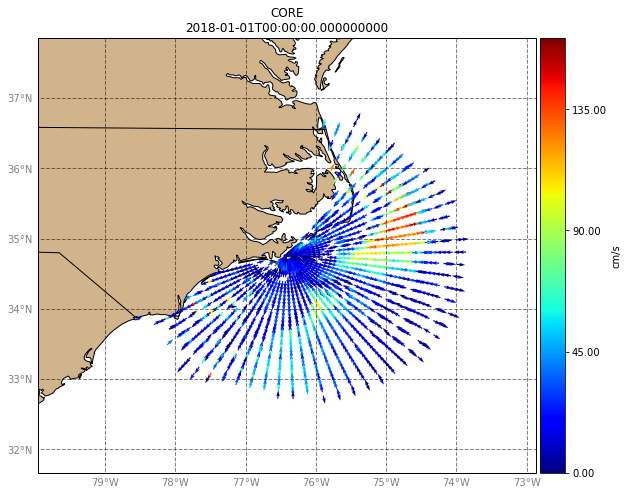

<Figure size 864x612 with 0 Axes>

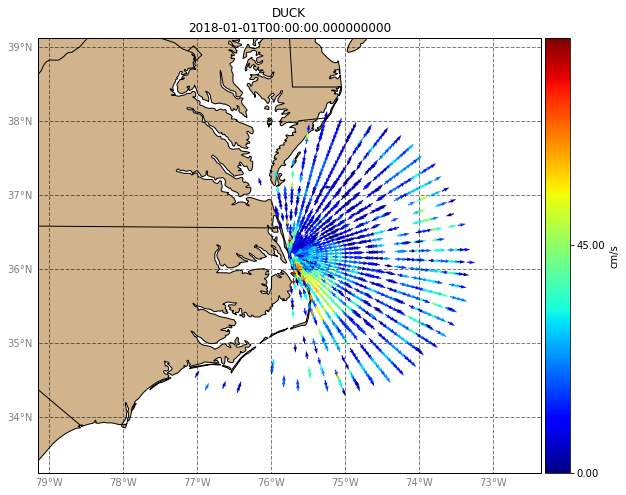

In [3]:
velocity_min = 0
velocity_max = 180
sub = 1

# Plot it directly from an xarray object
ncradialsplot(
    core_xr,
    velocity_min=velocity_min,
    velocity_max=velocity_max,
    sub=sub,
    title='CORE'
)
# Plot it directly from an xarray object
ncradialsplot(
    duck_xr,
    velocity_min=velocity_min,
    velocity_max=velocity_max,
    sub=sub,
    title='DUCK'
)

# Create a standard grid to output

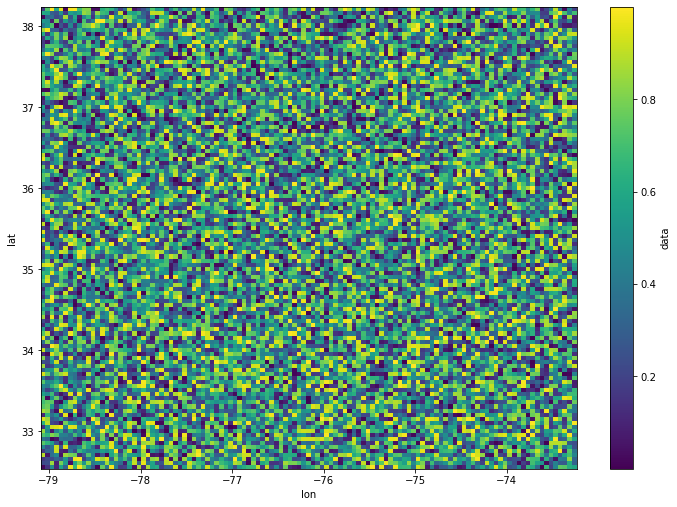

In [4]:
# Create a standard output grid that we will interpolate onto
import numpy as np
import xarray as xr

bottom_left_lat = min(core_xr.lat.data.min(), duck_xr.lat.data.min()) - 0.1
bottom_left_lon = min(core_xr.lon.data.min(), duck_xr.lon.data.min()) - 0.1

top_right_lat = max(core_xr.lat.data.max(), duck_xr.lat.data.max()) + 0.1
top_right_lon = max(core_xr.lon.data.max(), duck_xr.lon.data.max()) + 0.1

# Define grid spacing
spacing = 0.05
lat = np.arange(bottom_left_lat, top_right_lat, spacing)
lon = np.arange(bottom_left_lon, top_right_lon, spacing)
xx, yy = np.meshgrid(lon, lat)

ds = xr.Dataset(
    {
        'data': (['lat', 'lon'], np.random.rand(lat.size, lon.size))
    },
    coords={
        'lon': lon,
        'lat': lat
    }
)

# Create a magic eye
ds.data.plot()

# DUCK - interpolate onto output grid

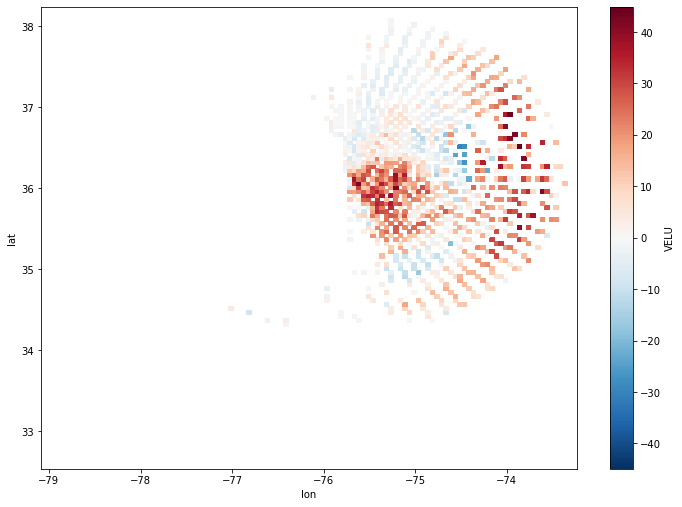

In [5]:
# Get indexes into the computed grid for each LOND and LATD defined in the data
duck_x_ind, duck_y_ind = gridded_index(xx, yy, duck_radial.data.LOND.values, duck_radial.data.LATD.values)

datas = {}
throw_away_columns = ['index', 'LOND', 'LATD']

for c in duck_radial.data.columns:
    e = np.ma.masked_all(shape=(lat.size, lon.size))
    e[duck_y_ind, duck_x_ind] = duck_radial.data[c].values
    datas[c] = e

duck_grid = xr.Dataset(
    { k: (['lat', 'lon'], v) for k, v in datas.items() if k not in throw_away_columns },
    coords={
        'lon': (['lon'], lon),
        'lat': (['lat'], lat),
    }
)
duck_grid.VELU.plot()

# CORE - interpolate onto output grid

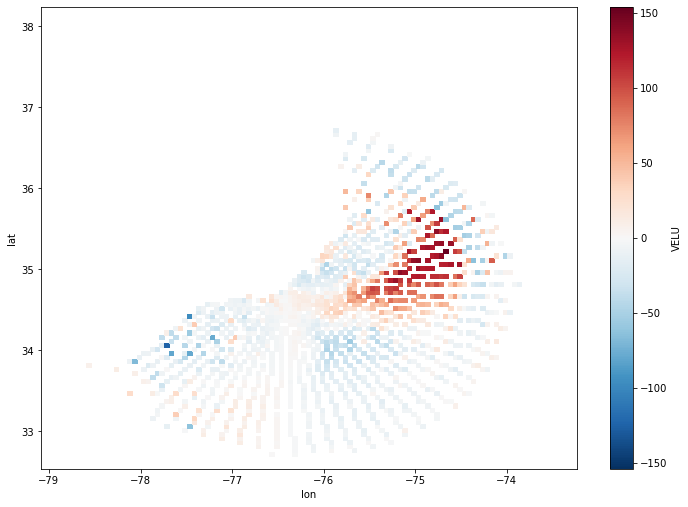

In [6]:
# Get indexes into the computed grid for each LOND and LATD defined in the data
core_x_ind, core_y_ind = gridded_index(xx, yy, core_radial.data.LOND.values, core_radial.data.LATD.values)

datas = {}
throw_away_columns = ['index', 'LOND', 'LATD']

for c in core_radial.data.columns:
    e = np.ma.masked_all(shape=(lat.size, lon.size))
    e[core_y_ind, core_x_ind] = core_radial.data[c].values
    datas[c] = e

core_grid = xr.Dataset(
    { k: (['lat', 'lon'], v) for k, v in datas.items() if k not in throw_away_columns },
    coords={
        'lon': (['lon'], lon),
        'lat': (['lat'], lat),
    }
)
core_grid.VELU.plot()

# Combine the data from both sites into a total vector product

In [7]:
import rads2uv

In [8]:
radial_velocities = [1, 2, 2, 1]
std_dev = [1, 1, 1, 1]
angles = [0, 45, 90, 1]
UV, VAR, n  = rads2uv.rads2uv(
    radial_velocities,
    std_dev,
    angles
)
print(UV, VAR, n)

[0.96090992 1.95589842] [0.40004874 0.66653132] 4


In [9]:
# dumb, but it works
duck_vel = duck_grid['VELO'].values.flatten()
duck_std = duck_grid['ESPC'].values.flatten()
# heading needs to be changed from clockwise from N to counter-clockwise from x-axis
# - add 90 to start from same origin
# - change sign
duck_theta = np.mod(-1 * duck_grid['HEAD'].values.flatten() + 90, 360)

core_vel = core_grid['VELO'].values.flatten()
core_std = core_grid['ESPC'].values.flatten()
core_theta = np.mod(-1 * core_grid['HEAD'].values.flatten() + 90, 360)

U = np.ones_like(core_vel)*np.nan
V = np.ones_like(core_vel)*np.nan
nvalues = len(U)

In [10]:
for i in range(nvalues):
    UV, VAR, n = rads2uv.rads2uv(
        [duck_vel[i], core_vel[i]],
        [duck_std[i], core_std[i]],
        [duck_theta[i], core_theta[i]]
    )
    U[i] = UV[0]
    V[i] = UV[1]

In [11]:
U = U.reshape(duck_grid['VELO'].shape)
V = V.reshape(duck_grid['VELO'].shape)

In [12]:
U.shape

(114, 117)

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfe

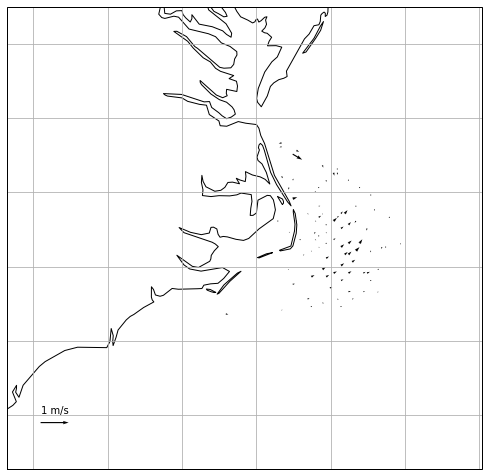

In [14]:
ax = plt.axes(projection=crs.PlateCarree())
ax.coastlines('50m')
ax.gridlines()
quiver = plt.quiver(
    duck_grid['lon'],
    duck_grid['lat'],
    U,
    V,
    transform=crs.PlateCarree(),
)
key = plt.quiverkey(
    quiver,
    0.1,
    0.1,
    1000,
    '1 m/s',
    coordinates='axes'
)